In [1]:
import re
import time
import os
import glob
from functools import partial, partialmethod


import math
from numpy import exp, array, insert
from math import log, sqrt, e

import numpy as np
from scipy import integrate
from scipy.optimize import differential_evolution

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.widgets import CheckButtons, Cursor

from refnx.analysis import Parameter, Parameters
from refnx.reflect import SLD, Slab, Structure, ReflectModel


# an alphanumeic sorter
def sorted_nicely(l):
    """Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

Simplified Trofimov-model solver

In [2]:
###############################################################################
###############      Trofimov-model for layer coverages         ###############
###############################################################################
def Xi2(Theta, ThetaC):
    rval = np.zeros_like(Theta)
   
    cond0 = Theta > ThetaC
    cond1 = np.logical_and(0 < Theta, Theta < 1)
    cond2 = np.logical_and(0 < ThetaC, ThetaC < 1)
    cond3 = cond0 & cond1 & cond2
    cond4 = Theta >= 1
    cond5 = ThetaC >= 1

    rval[cond0 & cond4] = 1.0
    rval[cond0 & cond5] = 1.0

    if cond3.any():
        expo1 = np.sqrt(-np.log(1 - Theta[cond3]))
        expo2 = np.sqrt(-np.log(1 - ThetaC[cond3]))
        rval[cond3] = 1 - np.exp(-(expo1 - expo2) * (expo1 - expo2))

    return rval

def trofimov(X, t, *args):
    """
    X: list of differential equations to solve
    t: independent variable
    args: Xc, R123
        Xc: list of theta criticals
        R123 = R1,R2,R3,R: growth rates for different layers
    """
    Xc, R123 = args
    R1, R2, R3, R = R123
    N = len(Xc)
    rval = np.zeros_like(Xc)

    # Rate equations for different rates for the first four ML
    xit = Xi2(X, Xc)
   
    if X[0] < 0.99999999:
        rval[0] = R1 * (1 - X[0]) + R2 * (X[0] - xit[0])

    rval[1] = R2 * (xit[0] - X[1]) + R * (X[1] - xit[1])
    rval[2] = R3 * (xit[1] - X[2]) + R * (X[2] - xit[2])
    rval[3:] = R * (xit[2:-1] - xit[3:])
    return rval


###############################################################################
###############     Functions for calculations      ###############
###############################################################################


def calc_all(N, t, R123, ThetaC):
    """Calculate coverages, thickness, roughness, reflectivity"""

    X0 = np.zeros(N)  
    X = integrate.odeint(trofimov, X0, t, args=(ThetaC, R123), mxstep=2000) #original
    np.clip(X, None, 1.0, out=X)
    coverages = np.transpose(X)  # Coverages in a.u.
    thickness = sum(coverages)   
    roughness = np.sqrt(abs(sum(
                [(coverages[i] - coverages[i + 1]) * (i + 1 - thickness) ** 2 for i in range(N - 1)]
            )
        )
    )
    roughness_f = roughness *16.6  # 16.6 Å (DIP monolayer thickness), the roughness for the experimental dataset
    thickness_f = thickness * 16.6 # 16.6 Å (DIP monolayer thickness), the thickness of the film
    return X, coverages, thickness_f, roughness_f

Parameters for the growth model

In [4]:
N = 35  # number of ML
times = np.linspace(0, 16, num=80) #time of the growth
x = np.linspace(0, N, N)

# parameters G - growth rates
G1 = Parameter(0.9, name="G1")
G2 = Parameter(0.7, name="G2")
G3 = Parameter(0.85, name="G3")
G4 = Parameter(1.09, name="G4")

# parameters to generate Theta criticals
a = Parameter(0.28, name="a") # parameter for the tanh() function
b = Parameter(0.6, name="b")  # parameter for the tanh() function
c = Parameter(0.2, name="c")  # parameter when to swich from tanh() to exp()
d = Parameter(-5.75, name="d") # exp() decay
g = Parameter(0.028, name="g") # exp() convergation

Theta criticals generation based on tanh() function and an exponential decay

In [5]:
def growth_model_thickness(times, N, G1, G2, G3, G4, a, b, c, d, g):
    G1, G2, G3, G4, a, b, c, d, g = map(float, [G1, G2, G3, G4, a, b, c, d, g])
    x = np.linspace(0, N, N)
    f = 0
    z = a*(((0.5*np.tanh(-0.5*(x+d))+0.5))/((0.5*np.tanh(-0.5*d)+0.5)))
    #print(z)
    for j in range (N):
        if z[j] > c:
            z[j] = z[j]
            f = j
        else:    
            z[j] = (c - g)* e ** (-b * x[j-f]) + g
    #print(z)
    gr = [G1, G2, G3, G4]

    thetacrit = z
    out = calc_all(N, times, gr, thetacrit)
    return out

In [6]:
pars = growth_model_thickness(times, N, G1, G2, G3, G4, a, b, c, d, g)

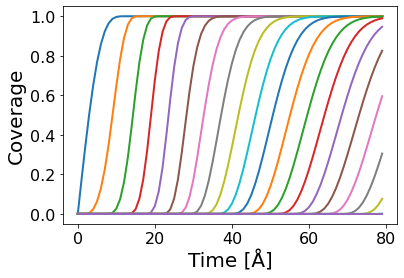

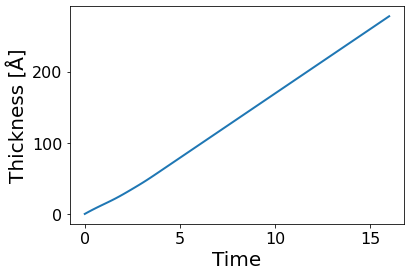

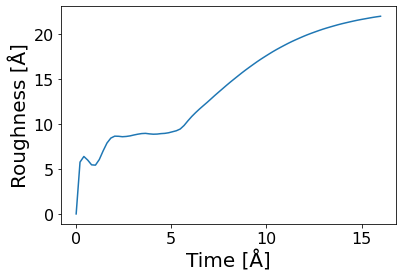

(80, 35) (35, 80)


In [7]:
plt.rcParams["font.size"] = "16"
for i in range(N):
    plt.plot(pars[0][:, i], linewidth=2)
plt.xlabel("Time [Å]", fontsize=20)
plt.ylabel("Coverage", fontsize=20)
plt.savefig("Coverage.svg", format="svg", dpi=1200)
plt.show()


# plt.figure(figsize=(8, 6), dpi=1200)
# Where on earth does this value of 16.6 come from?

plt.plot(times, pars[2], linewidth=2) #16.6 thickness of the one ML. pars[3] * 16.6 = real thickness
plt.xlabel("Time", fontsize=20)
plt.ylabel("Thickness [Å]", fontsize=20)
plt.savefig("Roughness.svg", format="svg", dpi=1200)
plt.show()

plt.plot(times, pars[3]) #16.6 thickness of the one ML. pars[3] * 16.6 = real roughness
plt.xlabel("Time", fontsize=20)
plt.ylabel("Roughness [Å]", fontsize=20)
plt.show()

print(pars[0].shape, pars[1].shape)

In [8]:
from refnx.dataset import Data1D
from refnx.analysis import Transform, Objective, GlobalObjective, Parameter, CurveFitter

files = sorted_nicely(glob.glob("data/DIP403_*.*"))
datasets = [Data1D(file) for file in files]
print(datasets[1])

<DIP403_1>, 109 points


In [10]:
thicks = Parameters()
sigmas = Parameters()
for t in times:
    p = Parameter(1, name=f"thick - {t}s")
    sigma = Parameter(1, name=f"sigma - {t}s")
    p.t = t
    sigma.t = t
    thicks.append(p)
    sigmas.append(sigma)

In [11]:
si = SLD(20.0, "Si")
air = SLD(0, "Air")
sio2 = SLD(19, "SiO2")
film_s = SLD(10, "film")

In [12]:
strucs = []
models = []
air_l = air()
sio2_l = sio2(10, 2.5)
si_l = si(0, 1)

for t, thick, sigma in zip(times, thicks, sigmas):
    film_l = Slab(thick, film_s, sigma)
    s = air_l | film_l | sio2_l | si
    strucs.append(s)
    mod = ReflectModel(s)
    mod.threads = 1
    mod.dq.value = 0.0
    models.append(mod)

________________________________________________________________________________
Parameters:      None      
<Parameter:'thick - 0.0s' , value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 0.20253164556962025s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 0.4050632911392405s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 0.6075949367088608s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 0.810126582278481s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 1.0126582278481013s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 1.2151898734177216s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 1.4177215189873418s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 1.620253164556962s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 1.8227848101265822s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thick - 2.0253164556962027s', value=1 (fixed)  , bounds=[-inf, inf]>
<Parameter:'thi

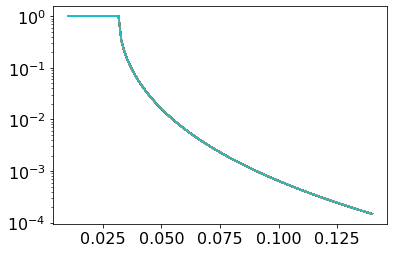

In [13]:
q = np.linspace(0.01, 0.14, 109)
for s in strucs:
    plt.plot(q, s.reflectivity(q))

plt.yscale("log")

In [14]:
G1.setp(vary=True, bounds=(0.5, 1.1))
G2.setp(vary=True, bounds=(0.5, 1.1))
G3.setp(vary=True, bounds=(0.7, 1.2))
G4.setp(vary=True, bounds=(0.9, 1.7))
a.setp(vary=True, bounds=(0.2, 0.6)) # max 0.7, after that the integration is taking too long
b.setp(vary=True, bounds=(0.05, 0.7))
c.setp(vary=True, bounds=(0.11, 0.4))
d.setp(vary=True, bounds=(-7, 0))
g.setp(vary=True, bounds=(0.002, 0.12))

film_l.sld.real.setp(vary=True, bounds=(5, 20))



In [15]:
t = Transform("logY")

objectives = [
    Objective(model, data, use_weights=False, transform=t)
    for model, data in zip(models, datasets)
]
objectives[0].auxiliary_params = Parameters(
    data=(G1, G2, G3, G4, a, b, c, d, g)
)
global_objective = GlobalObjective(objectives)

In [16]:
def wrapper(
    global_objective, thicks, sigmas, times, N, G1, G2, G3, G4, a, b, c, d, g
):
    def cost_to_minimise(x):

        global_objective.setp(x)
        
        _X, _cov, ts, rs = growth_model_thickness(times, N, G1, G2, G3, G4, a, b, c, d, g)
        
        for thick, sigma, t, r in zip(thicks, sigmas, ts, rs):
            
            thick.value = t
            assert np.isfinite(t)
            sigma.value = r
            assert np.isfinite(r)
        try:
            plp = global_objective.nll()
            return plp
        except RuntimeError as exc:
            print(global_objective.varying_parameters())
            print(ts)
            raise exc

    return cost_to_minimise

bounds = [(p.bounds.lb, p.bounds.ub) for p in global_objective.varying_parameters()]
cost = wrapper(
    global_objective, thicks, sigmas, times, N, G1, G2, G3, G4, a, b, c, d, g
)

def callback(x, *args, **kwds):
    pass

In [17]:
cost(global_objective.varying_parameters())

135.58709262755028

In [18]:
%timeit growth_model_thickness(times, N, G1, G2, G3, G4, a, b, c, d, g)

301 ms ± 45.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit cost(global_objective.varying_parameters())

367 ms ± 7.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A large proportion of time seems to be spent in solving the differential equation.

In [20]:
res = differential_evolution(cost, bounds, polish=True, seed=2, callback=callback)

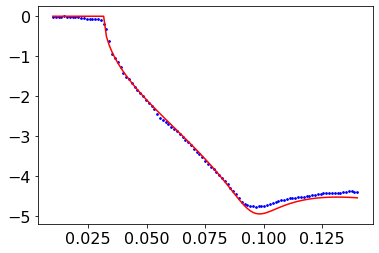

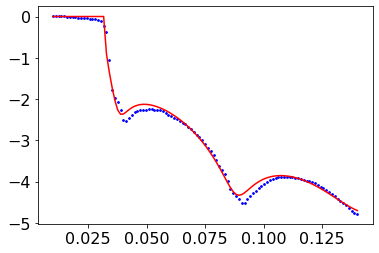

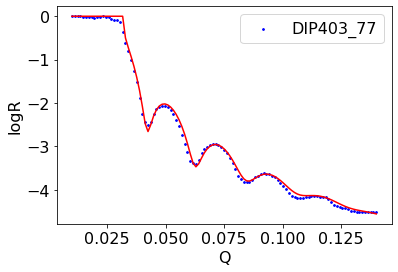

In [21]:
objectives[11].plot()
objectives[33].plot()
objectives[77].plot()
plt.legend()
plt.xlabel("Q")
plt.ylabel("logR");
# plt.yscale('log')

In [22]:
objectives[-1].model.structure.slabs()

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [276.07536797,  11.04124549,   0.        ,  21.77371835,
          0.        ],
       [ 10.        ,  19.        ,   0.        ,   2.5       ,
          0.        ],
       [  0.        ,  20.        ,   0.        ,   0.        ,
          0.        ]])

In [24]:
print(repr(np.array(thicks)))
print(repr(np.array(sigmas)))

array([  0.        ,   3.53801459,   6.78722055,   9.79325396,
        12.62280513,  15.35191372,  18.05017715,  20.75474562,
        23.4857939 ,  26.25526201,  29.07155125,  31.94363833,
        34.88121913,  37.89305036,  40.98628202,  44.16540043,
        47.43113822,  50.77989378,  54.20392934,  57.6923022 ,
        61.23229157,  64.81098525,  68.41667641,  72.03979746,
        75.67327806,  79.3123917 ,  82.95428403,  86.59740446,
        90.24100238,  93.8847595 ,  97.52856059, 101.17237129,
       104.81618354, 108.45999597, 112.1038084 , 115.74762083,
       119.39143327, 123.0352457 , 126.67905814, 130.32287057,
       133.96668301, 137.61049544, 141.25430788, 144.89812031,
       148.54193275, 152.18574518, 155.82955762, 159.47337005,
       163.11718249, 166.76099492, 170.40480736, 174.04861979,
       177.69243223, 181.33624466, 184.9800571 , 188.62386953,
       192.26768197, 195.9114944 , 199.55530684, 203.19911927,
       206.84293171, 210.48674414, 214.13055658, 217.77

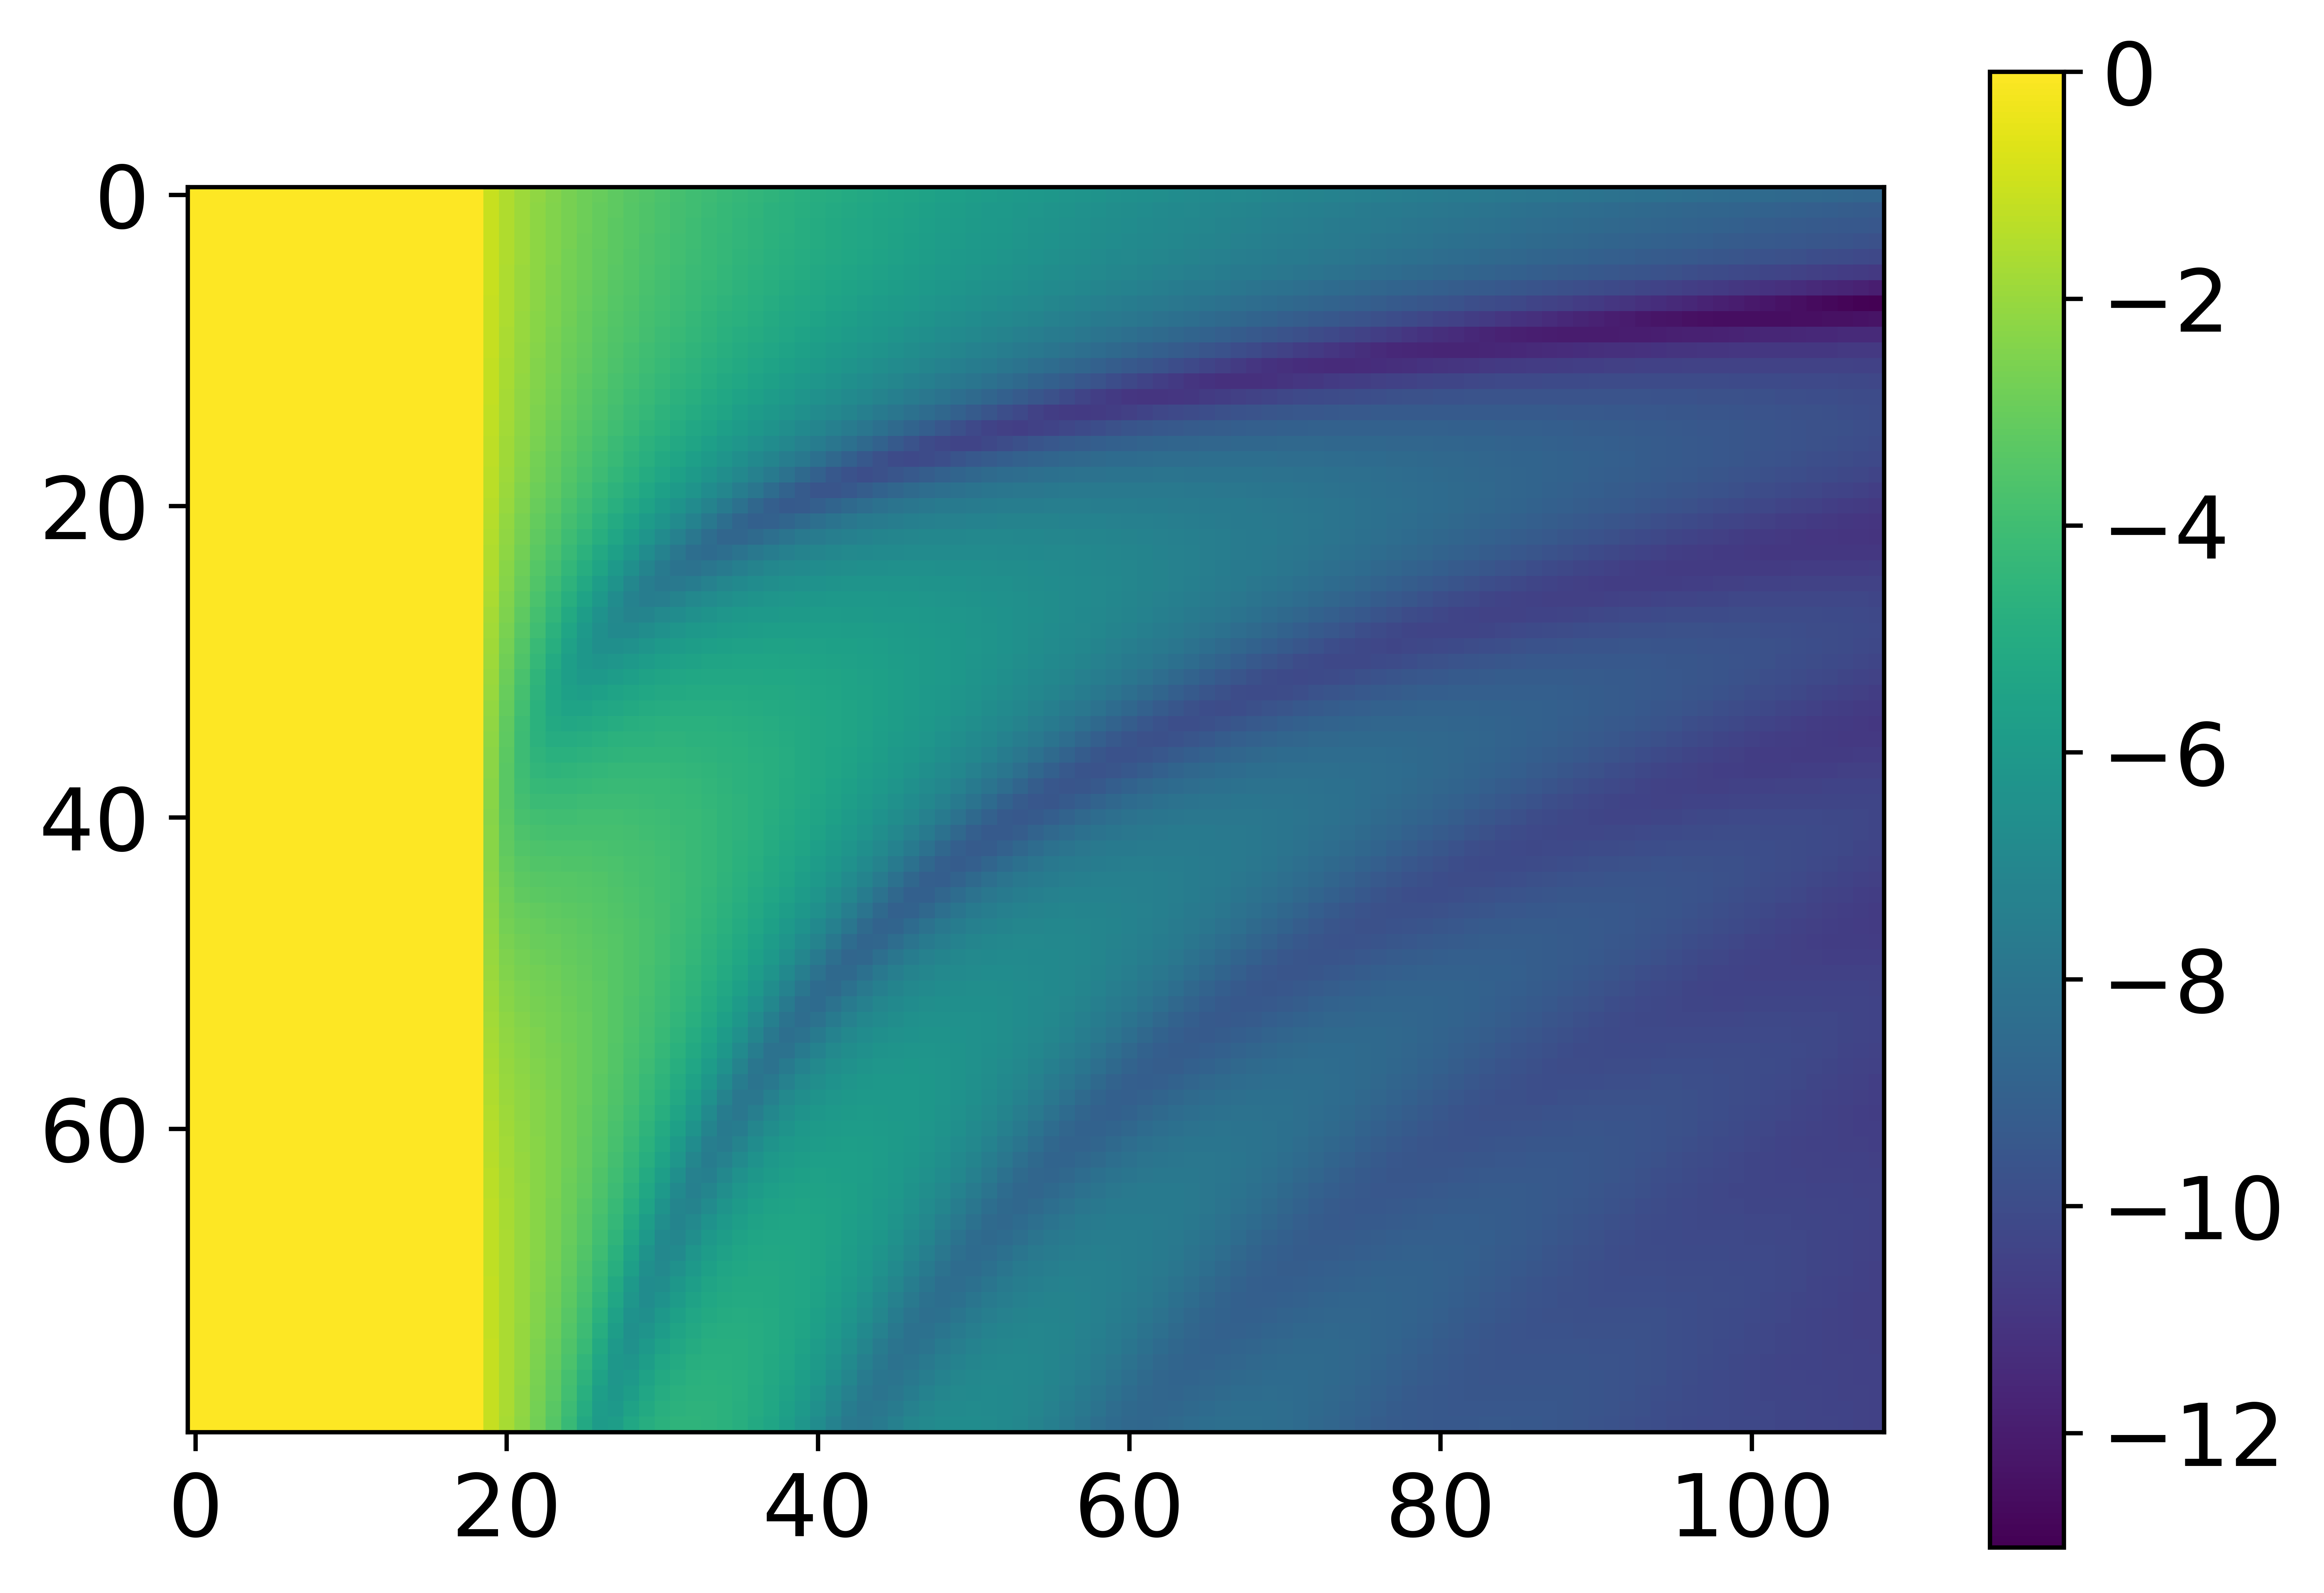

In [26]:
out = np.array([objective.generative() for objective in objectives])
#plt.figure(figsize=(7, 5), dpi=1200)
plt.imshow(np.log(out))
plt.colorbar()